In [77]:
! pip install plotly

     |████████████████████████████████| 21.8 MB 10.6 MB/s eta 0:00:01   |█████▉                          | 4.0 MB 3.6 MB/s eta 0:00:05


In [78]:
import statsmodels as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set_theme(style="darkgrid")

In [64]:
comp_prices_df = pd.read_csv("../data/comp_prices.csv")
sales_df = pd.read_csv("../data/sales.csv")


In [66]:
comp_prices_df.columns = list(map(str.lower, comp_prices_df.columns))
comp_prices_df["date_extraction"] = pd.to_datetime(comp_prices_df["date_extraction"])
comp_prices_df["date"] = pd.to_datetime(comp_prices_df["date_extraction"].dt.date)
comp_prices_df

prod_id     date_extraction competitor  competitor_price  pay_type  \
0          P6 2015-01-30 08:11:38         C3           1898.00         1   
1          P6 2015-01-30 08:11:38         C1           1898.00         1   
2          P6 2015-01-30 08:11:38         C6           1999.90         1   
3          P6 2015-01-31 20:10:14         C2           1894.88         2   
4          P6 2015-01-31 20:10:14         C3           1894.88         2   
...       ...                 ...        ...               ...       ...   
50109      P5 2015-10-11 20:10:34         C1            819.00         2   
50110      P5 2015-10-11 20:10:34         C2            853.52         2   
50111      P5 2015-10-12 08:11:27         C2            853.52         1   
50112      P5 2015-10-12 08:11:27         C3            819.00         1   
50113      P5 2015-10-12 08:11:27         C1            819.00         1   

            date  
0     2015-01-30  
1     2015-01-30  
2     2015-01-30  
3     2015-01-31  
4     2015-01-31  
...          ...  
50109 2015-10-11  
50110 2015-10-11  
50111 2015-10-12  
50112 2015-10-12  
50113 2015-10-12  

[50114 rows x 6 columns]

In [67]:
sales_df.columns = list(map(str.lower, sales_df.columns))
sales_df["date_order"] = pd.to_datetime(sales_df.date_order)
sales_df["value_per_item"] = sales_df.revenue/sales_df.qty_order
sales_df

prod_id date_order  qty_order  revenue  value_per_item
0           P6 2015-08-02        1.0  1808.99         1808.99
1           P6 2015-08-17        1.0  1674.00         1674.00
2           P6 2015-08-17        1.0  1673.95         1673.95
3           P6 2015-08-11        1.0  1674.00         1674.00
4           P6 2015-08-17        1.0  1674.00         1674.00
...        ...        ...        ...      ...             ...
351086      P3 2015-09-24        1.0  1008.83         1008.83
351087      P3 2015-10-13        2.0  2333.92         1166.96
351088      P3 2015-09-24        1.0  1311.81         1311.81
351089      P3 2015-10-13        1.0  1166.96         1166.96
351090      P3 2015-10-10        1.0  1166.96         1166.96

[351091 rows x 5 columns]

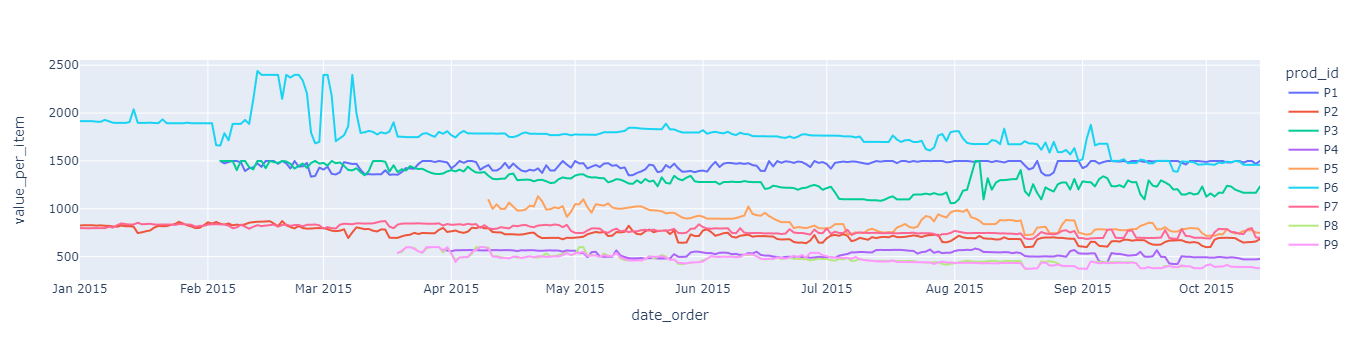

In [87]:
fig = px.line(sales_df.groupby(["prod_id", "date_order"]).agg({"value_per_item" : "mean"}).reset_index(), x="date_order", y="value_per_item", color="prod_id")
fig.show()

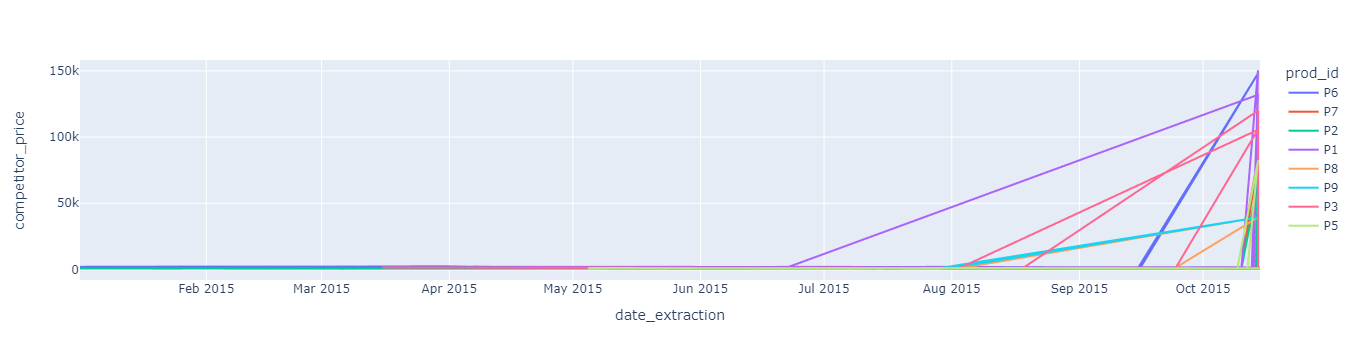

In [96]:
px.line(comp_prices_df[(comp_prices_df.competitor == "C1")], x="date_extraction", y="competitor_price", color="prod_id")

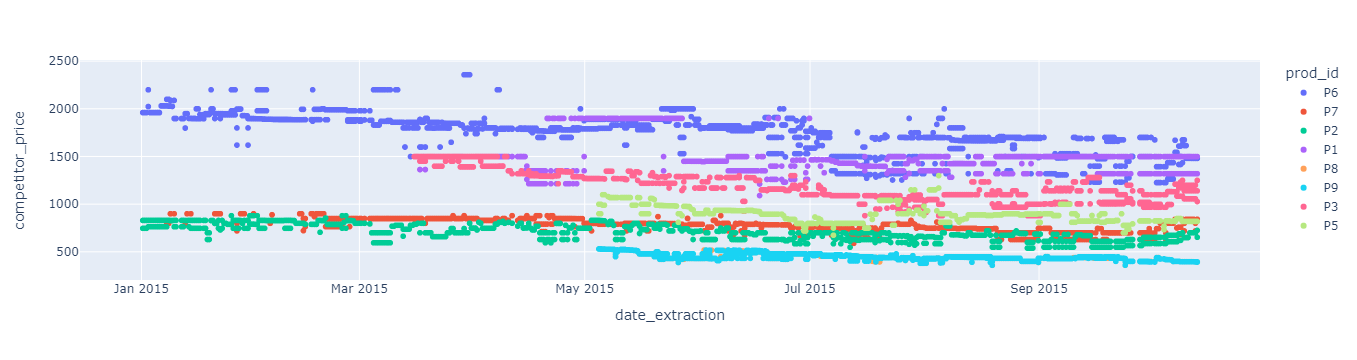

In [98]:
comp_prices_df = comp_prices_df[comp_prices_df.date != pd.to_datetime("2015-10-14")]
px.scatter(comp_prices_df[(comp_prices_df.competitor == "C1")], x="date_extraction", y="competitor_price", color="prod_id")

In [99]:

price_df = pd.concat([    
    comp_prices_df.groupby(["competitor","prod_id","date"])\
        .agg({"competitor_price" : "median"})\
        .reset_index()\
        .rename(columns={"competitor" : "company",
                         "competitor_price" : "price"}),
    sales_df.groupby(["prod_id", "date_order"])
            .agg({"value_per_item" : "median"})\
            .reset_index()\
            .rename(columns={"value_per_item" : "price",
                             "date_order" : "date"})\
            .assign(company="A")
])
price_df["date"] = pd.to_datetime(pd.to_datetime(price_df["date"]))

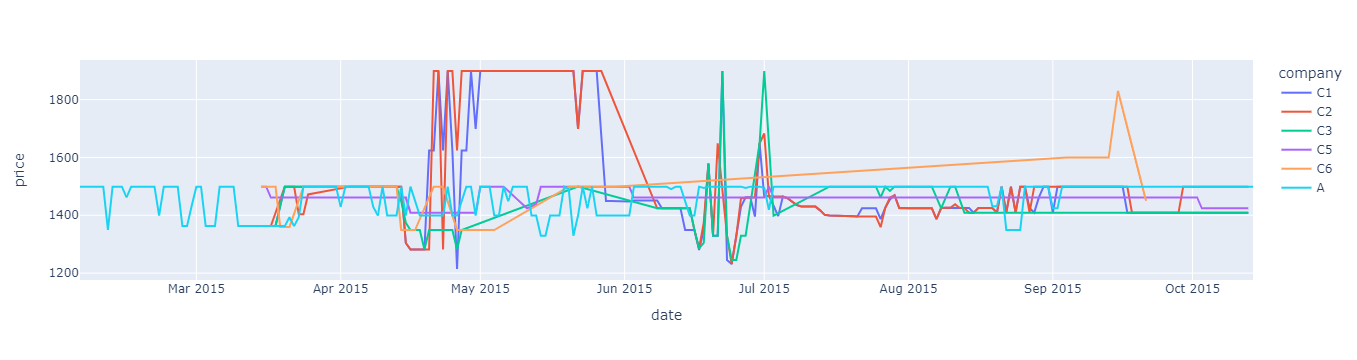

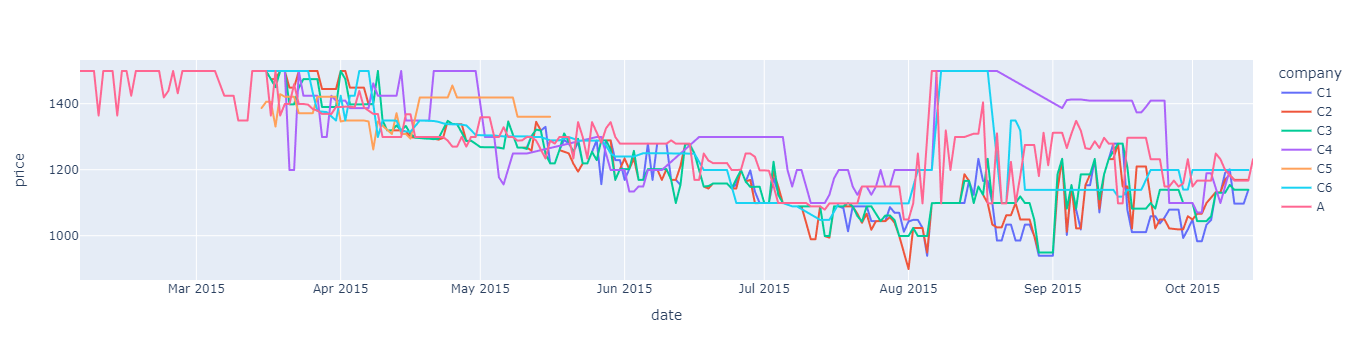

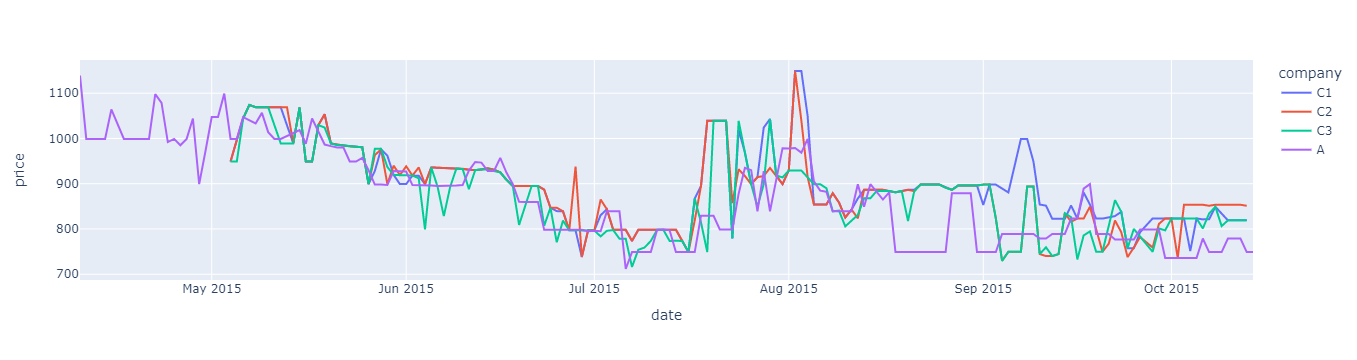

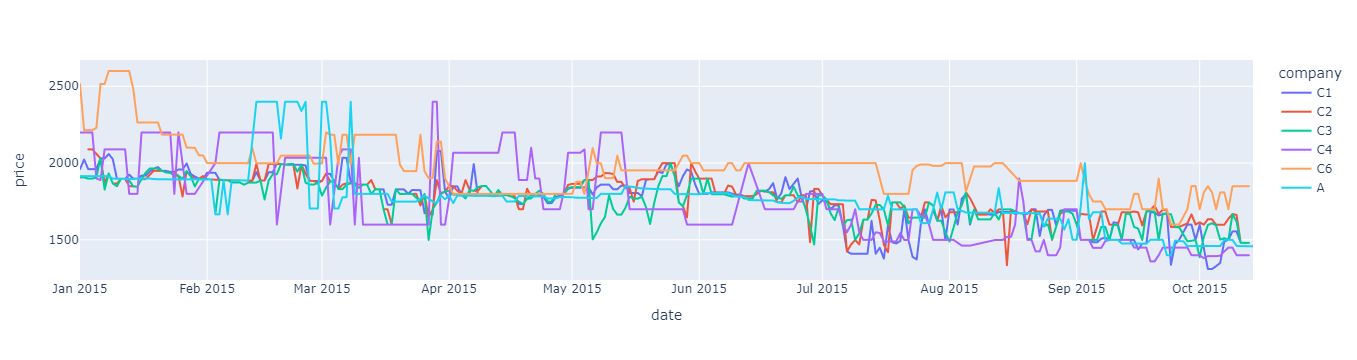

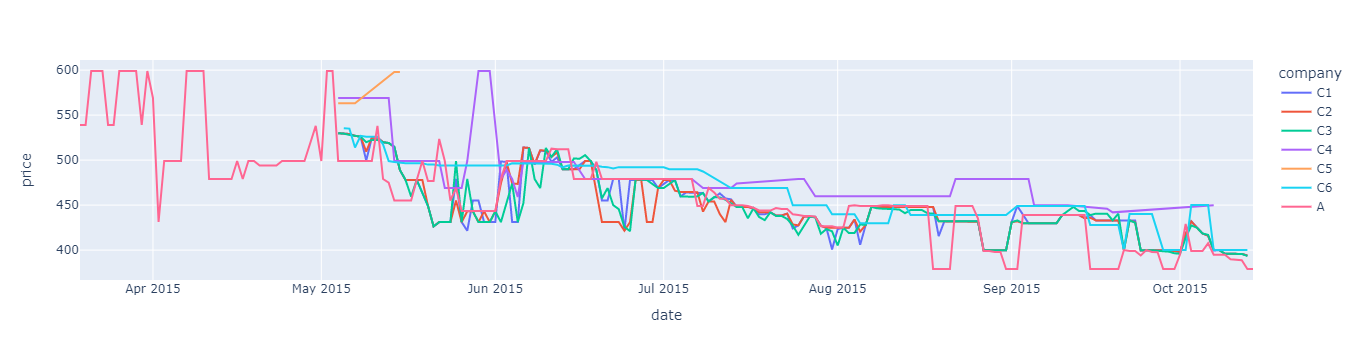

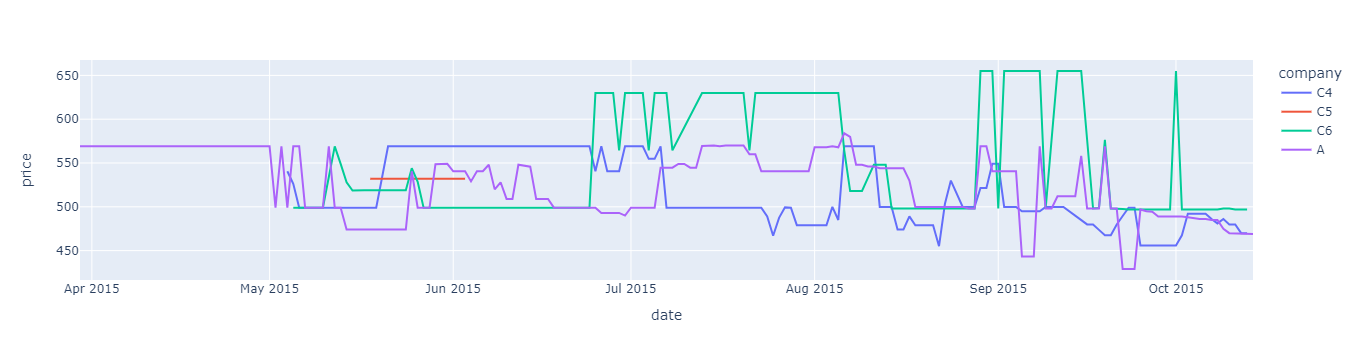

In [107]:
for prod_id in price_df.prod_id.unique():
    fig = px.line(price_df[(price_df.prod_id == prod_id)], x="date", y="price", color='company')
    fig.show()

In [120]:
sales_df

prod_id date_order  qty_order  revenue  value_per_item
0           P6 2015-08-02        1.0  1808.99         1808.99
1           P6 2015-08-17        1.0  1674.00         1674.00
2           P6 2015-08-17        1.0  1673.95         1673.95
3           P6 2015-08-11        1.0  1674.00         1674.00
4           P6 2015-08-17        1.0  1674.00         1674.00
...        ...        ...        ...      ...             ...
351086      P3 2015-09-24        1.0  1008.83         1008.83
351087      P3 2015-10-13        2.0  2333.92         1166.96
351088      P3 2015-09-24        1.0  1311.81         1311.81
351089      P3 2015-10-13        1.0  1166.96         1166.96
351090      P3 2015-10-10        1.0  1166.96         1166.96

[351091 rows x 5 columns]

In [156]:
df = pd.merge(sales_df.rename(columns={"date_order":"date"})\
             .groupby(["prod_id",
                            "date",
                            "value_per_item"])\
             .agg({"qty_order" : "sum"})\
             .reset_index(),
          comp_prices_df.groupby(["prod_id","date"])\
              .competitor_price.agg(["min","max","mean", "median"])\
              .reset_index(),
         on=["date", "prod_id"]
          )
df

prod_id       date  value_per_item  qty_order     min     max       mean  \
0         P1 2015-03-15         1294.38        1.0  1499.0  1499.0  1499.0000   
1         P1 2015-03-15         1347.51        1.0  1499.0  1499.0  1499.0000   
2         P1 2015-03-15         1362.50       46.0  1499.0  1499.0  1499.0000   
3         P1 2015-03-16         1362.50       17.0  1362.5  1499.0  1464.2050   
4         P1 2015-03-16         1499.00        7.0  1362.5  1499.0  1464.2050   
...      ...        ...             ...        ...     ...     ...        ...   
9164      P9 2015-10-13          360.05        1.0   393.0   569.0   419.4075   
9165      P9 2015-10-13          379.00      257.0   393.0   569.0   419.4075   
9166      P9 2015-10-13          388.63       62.0   393.0   569.0   419.4075   
9167      P9 2015-10-13          394.90        2.0   393.0   569.0   419.4075   
9168      P9 2015-10-13          449.00        1.0   393.0   569.0   419.4075   

      median  
0     1499.0  
1     1499.0  
2     1499.0  
3     1499.0  
4     1499.0  
...      ...  
9164   394.0  
9165   394.0  
9166   394.0  
9167   394.0  
9168   394.0  

[9169 rows x 8 columns]

## Pontos a se levar em consideração

- Produtos muito baratos podem ser vendidos em pouca quantidade pois não tem estoque.
- O número de vendas depende do numero de pessoas querendo comprar aquele produto, que pode ser uma função do dia (dia da semana, dia do ano), do histórico


## Possibilidades:

- Agregar preço médio ponderando pelo numero de vendas?

In [157]:
df = pd.merge(df,
         df.groupby(["prod_id", "date"])\
         .agg({"qty_order" : "mean"})\
         .rename(columns={"qty_order" : "qty_day"}),
        on=["prod_id", "date"])

In [158]:
df["diff_min_pct"] = (df.value_per_item - df["min"])/df["min"]
df["diff_mean_pct"] = (df.value_per_item - df["mean"])/df["mean"]

In [168]:
px.scatter(df[(df.prod_id == "P2") & (df.qty_order > 0)], x="diff_mean_pct", y="qty_order")

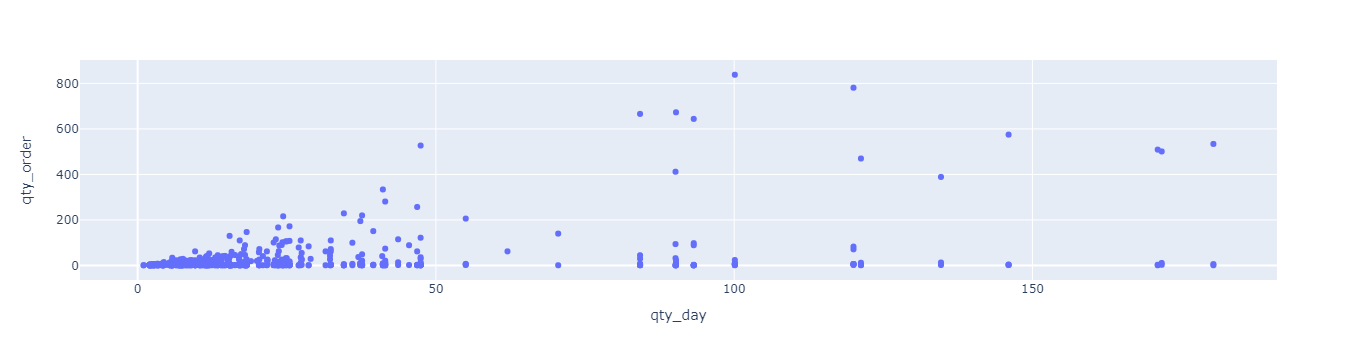

In [160]:
px.scatter(df[(df.prod_id == "P9") & (df.qty_order > 0)], x="qty_day", y="qty_order")

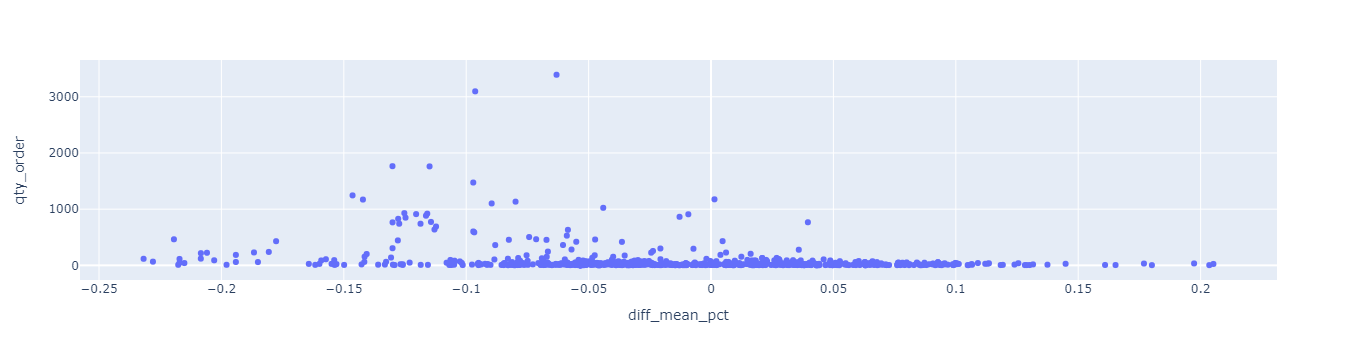

In [167]:
px.scatter(df[(df.prod_id == "P2") & (df.qty_order > 0) & (df.qty_order/df.qty_day > 0.5)], x="diff_mean_pct", y="qty_order")

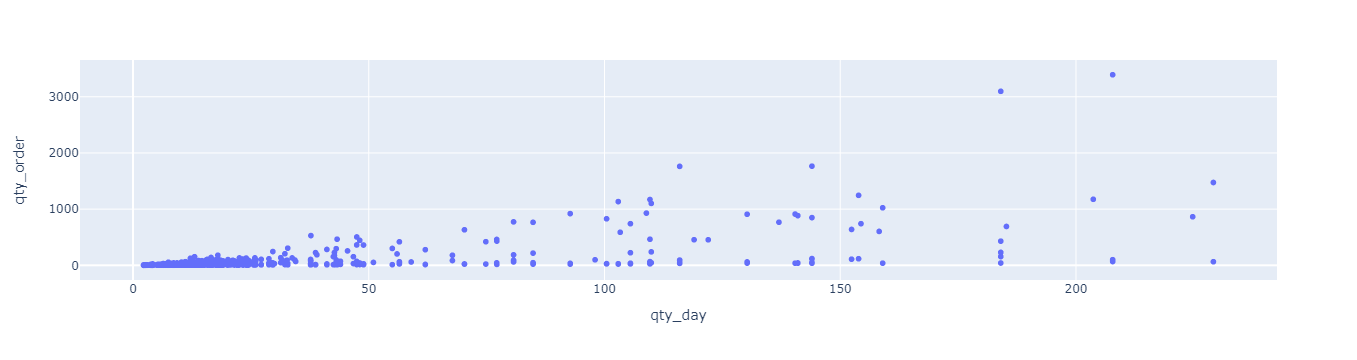

In [170]:
px.scatter(df[(df.prod_id == "P2") & (df.qty_order > 0) & (df.qty_order/df.qty_day > 0.2)], x="qty_day", y="qty_order")

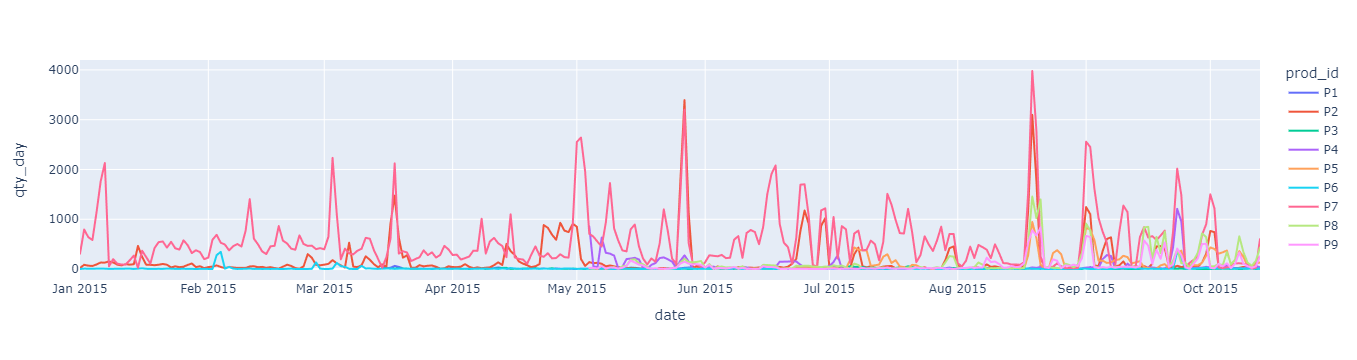

In [174]:
px.line(df.groupby(["prod_id", "date"])\
         .agg({"qty_order" : "max"})\
         .rename(columns={"qty_order" : "qty_day"})\
         .reset_index(), x="date", y="qty_day", color="prod_id")